In [47]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [48]:
mnist_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=mnist_transform, download=True
)

In [49]:
def showImageList(images):
    # show images side by side
    fig = plt.figure(figsize=(20, 5))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i  + 1)
        ax.axis("off")
        ax.imshow(image.squeeze(), cmap="gray", vmin=0, vmax=1)

In [34]:
H = 32
t = 0.75
t_scheduled = t ** (1 / 2)
int(H * (1 - t_scheduled) + 2 * t_scheduled)

6

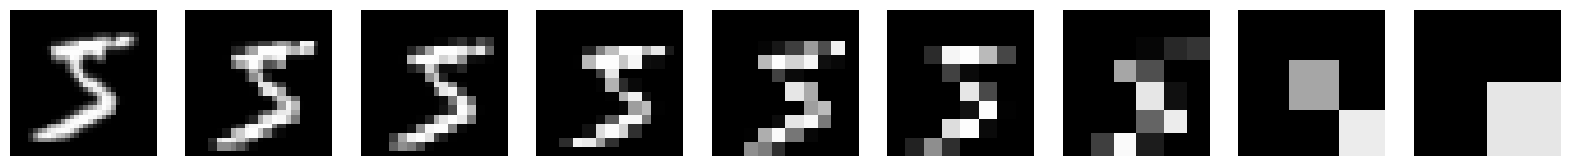

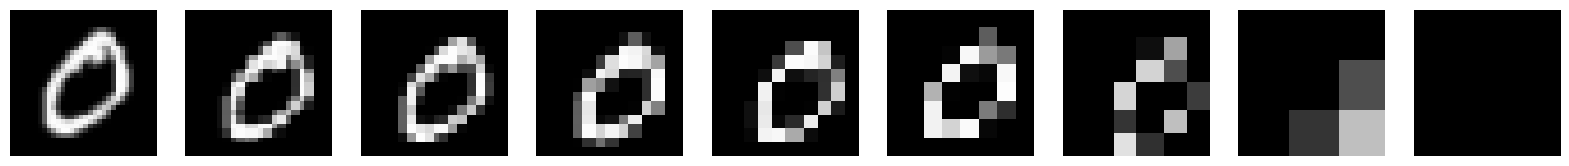

In [46]:
import torch.nn.functional as F


def pixelate(img_tensor, t):    
    # Calculate the reduced resolution
    C, H, W = img_tensor.shape

    # Calculate new size based on t
    t_scheduled = t ** (1 / 2)
    new_size = int(H * (1 - t_scheduled) + 2 * t_scheduled)

    # Resize down (pixelate)
    small_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(new_size, new_size), mode="nearest")

    # Resize back up
    return F.interpolate(small_tensor, size=(H, W), mode='nearest').squeeze(0)

test_image = train_dataset[4][0]

T = 8

for i in range(2):
    showImageList([
        pixelate(train_dataset[i][0], t/T) for t in range(0, T + 1)
    ])

In [210]:
n_between = 10
t = 10
((n_between - t + 1) % (n_between + 1)) / (
            n_between
        )

0.1

In [229]:
n_between = 5
t = 1
-1/(n_between - 1) * t + n_between/(n_between-1)

1.0

In [231]:
int(math.log2(16) - math.log2(8))

1

30

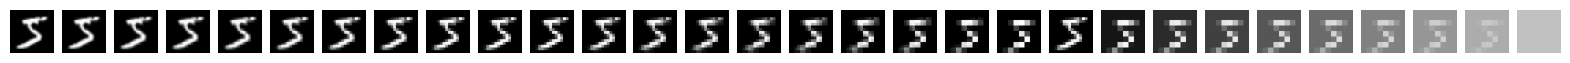

In [228]:
class Pixelate:
    def __init__(self, n_between: int = 1):
        self.n_between = n_between
        self.interpolation = transforms.InterpolationMode.NEAREST

    def calculate_T(self, image_size):
        """
        img0 -> img1/N -> img2/N -> .. -> img(N-1)/N -> img1 -> img(N+1)/N ->... imgK
        Where a fractional image denotes an interpolation between two images (imgA and img(A+1))
        """
        size = image_size
        count = 0
        while size > 4:
            count += 1
            size //= 2
        return count * self.n_between

    def set_to_random_grey(self, images: torch.Tensor, seed: int = None):
        if seed is not None:
            torch.manual_seed(seed)

        # Generate a different random grey value for each image in the batch
        random_greys = torch.rand(images.shape[0], 1, 1, 1).to(images.device)
        return images * 0 + random_greys

    def __call__(self, images: torch.Tensor, t: int, seed: int = None):
        """
        t = 0 -> no pixelation
        t = T -> full pixelations
        """

        if isinstance(t, torch.Tensor):
            t = t.item()
        image_size = images.shape[-1]

        from_index = t // (self.n_between + 1)
        current_level = (t - 1) // self.n_between  # Find out which segment t is in
        relative_t = t - current_level * self.n_between  # Position of t within that segment
    
        interpolation = -1 / (self.n_between - 1) * relative_t + self.n_between / (self.n_between-1)

        from_size = image_size // (2 ** (from_index + 1))

        if from_size <= 4:
            from_images = self.set_to_random_grey(images, seed)
        else:
            from_transform = transforms.Compose(
                [
                    transforms.Resize(from_size, self.interpolation),
                    transforms.Resize(image_size, self.interpolation),
                ]
            )
            from_images = from_transform(images)

        to_size = image_size // (2 ** (from_index))

        to_transform = transforms.Compose(
            [
                transforms.Resize(to_size, self.interpolation),
                transforms.Resize(image_size, self.interpolation),
            ]
        )

        to_images = to_transform(images)

        return (1 - interpolation) * from_images + interpolation * to_images
        
pixelate = Pixelate(10)

T = pixelate.calculate_T(32)

for i in range(1):
    showImageList([
        pixelate(train_dataset[i][0], t, seed=1) for t in range(1, T + 1)
    ])

len([
        pixelate(train_dataset[0][0], t, seed=1) for t in range(1, T + 1)
    ])

In [190]:
import math
int(math.log2(32) - math.log2(8))

2

31

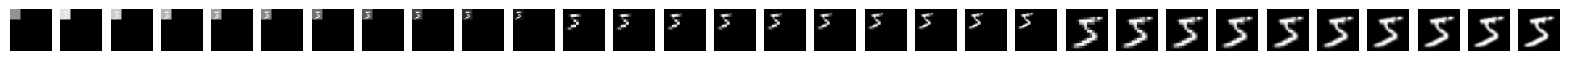

In [186]:
from utils import upscale_images
import math

class Pixelate:
    def __init__(self, n_between: int = 1):
        self.n_between = n_between
        self.interpolation = transforms.InterpolationMode.NEAREST

    def calculate_T(self, image_size):
        """
        img0 -> img1/N -> img2/N -> .. -> img(N-1)/N -> img1 -> img(N+1)/N ->... imgK
        Where a fractional image denotes an interpolation between two images (imgA and img(A+1))
        """
        size = image_size
        count = 0
        while size > 4:
            count += 1
            size //= 2
        return count * (self.n_between + 1) - 1

    def set_to_random_grey(self, images: torch.Tensor, seed: int = None):
        if seed is not None:
            torch.manual_seed(seed)

        # Generate a different random grey value for each image in the batch
        random_greys = torch.rand(images.shape[0], 1, 1, 1).to(images.device)
        return images * 0 + random_greys

    def __call__(self, images: torch.Tensor, t: int, seed: int = None):
        """
        t = 0 -> no pixelation
        t = T -> full pixelations
        """

        if isinstance(t, torch.Tensor):
            t = t.item()
        image_size = images.shape[-1]

        from_index = t // (self.n_between + 1)
        interpolation = ((self.n_between - t) % (self.n_between + 1)) / (
            self.n_between + 1
        )

        from_size = image_size // (2 ** (from_index + 1))

        if from_size <= 4:
            from_images = self.set_to_random_grey(images, seed)
        else:
            from_transform = transforms.Compose(
                [
                    transforms.Resize(from_size, self.interpolation),
                    transforms.Resize(image_size, self.interpolation),
                ]
            )
            from_images = from_transform(images)

        if interpolation == 0:
            return from_images
        else:
            to_size = image_size // (2 ** (from_index))

            to_transform = transforms.Compose(
                [
                    transforms.Resize(to_size, self.interpolation),
                    transforms.Resize(image_size, self.interpolation),
                ]
            )

            to_images = to_transform(images)

            return (1 - interpolation) * from_images + interpolation * to_images

class RandomColorInitializer():
    def sample(self, n_sample, size, label):
        # Sample a random grey image
        color = torch.rand(1)
        return torch.ones(n_sample, 1, size[-1], size[-1]) * color

sample_initializer = RandomColorInitializer()
n_between = 10
degredation = Pixelate(n_between)
final = train_dataset[0][0]
size = final.shape
min_size = 8
x_t = sample_initializer.sample(1, (min_size, min_size), 0)
# Sample random seed
seed = torch.randint(0, 100000, (1,)).item()

images = [x_t]

current_size = min_size

while current_size <= size[-1]:
    levels_left = int(math.log2(current_size) - math.log2(min_size) + 1)
    for t in range(n_between, 0, -1):
        t_is = torch.tensor([t / T])

        x_0 = F.interpolate(final.unsqueeze(0), size=(current_size, current_size), mode="nearest")

        x_t = degredation(x_0, (t - 1), seed)

        images.append(x_t)

    current_size *= 2

    if current_size <= size[-1]:
        x_t = upscale_images(x_t, current_size)

# Pad images to be the same size so it is centered

images = [F.pad(image, (0, size[-1] - image.shape[-1], 0, size[-1] - image.shape[-1])) for image in images]

showImageList(images)
len(images)